(20, 20, 20)
Time: 0.0031387805938720703 s for 40 molecules with 20 atoms


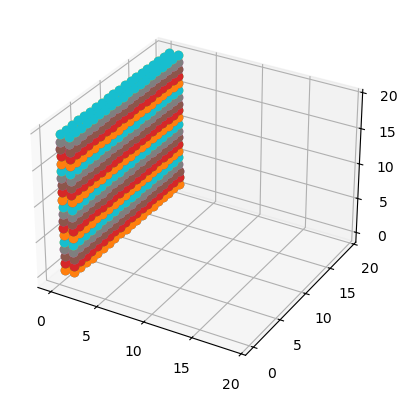

Nematic order parameter: 0.9998966455459595


In [47]:
import freud
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import csv


start_time = time.time()  # Starting a timer
nematic = freud.order.Nematic() # Required for NOP

class System:  # The array within which the molecules will sit
    def __init__(self, mol_len, num_mols, atom_sequence=0, density=1):  # Default density is 1 gram per cm^3
        self.mol_len = mol_len
        self.num_mols = num_mols
        self.atom_sequence = atom_sequence
        self.density = density
        self.all_paths = []
        self.sys_state = np.array([])
        self.sys_hist = []
        self.array = np.array([0])
        self.box_length = 0
        self.rollback = 5 + int(np.ceil(self.mol_len / 1000))
        self.rollback_count = 0
        self.mega_undo_count = 0
        self.pos = np.array([])
        self.pos_hist = []
        self.finished_mols = np.array([])
        self.mol_pos = []
        self.bonds = []
        self.bondshistory = []

    def save(self, position):
        """Saves the system such that it can be rolled back."""
        self.sys_state = np.copy(self.array)
        self.pos = position.copy()
        self.sys_hist.append(np.copy(self.sys_state))
        self.pos_hist.append(self.pos.copy())

    def undo(self):
        """Returns system state back to before the random moves were made."""
        self.array = np.copy(self.sys_state)
        position = self.pos.copy()
        self.rollback_count += 1
        return position

    def mega_undo(self):
        """Reverts system state back to a previous version."""
        if len(self.sys_hist) > 0:
            self.sys_state = self.sys_hist.pop()
            self.array = self.sys_state
            self.pos = self.pos_hist.pop()
            self.mega_undo_count += 1
            self.rollback_count = 0
        return self.pos

    def save_mol(self, position):
        """Saves a system state where a molecule was successfully created."""
        self.finished_mols = np.copy(self.array)
        self.mol_pos = position.copy()

    def undo_mol(self):
        """Reverts system and position to where a molecule was last successfully created."""
        if len(self.finished_mols) > 0:
            self.array = np.copy(self.finished_mols)
            position = self.mol_pos.copy()
            self.rollback_count = 0  # Reset counters after undo_mol
            self.mega_undo_count = 0
        else:
            self.reset()
            position = self.start_pos()
        return position

    def start_pos(self):
        """Checks to see if a random starting position is occupied."""
        while True:
            temp = np.array([random.randint(0, self.box_length - 1), random.randint(0, self.box_length - 1), random.randint(0, self.box_length - 1)])
            if self.array[temp[0], temp[1], temp[2]] != 1:
                break
        return temp

    def reset(self):
        """Removes all placed atoms."""
        self.array.fill(0)
        self.sys_hist = []
        self.pos_hist = []
        self.rollback_count = 0
        self.mega_undo_count = 0

    def plot(self):
        """Graphs the paths of the creation of the molecules."""
        print("Time:", time.time() - start_time, "s for", len(self.all_paths), "molecules with", self.mol_len, "atoms")
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for path in self.all_paths:
            path = np.array(path)
            ax.plot(path[:, 0], path[:, 1], path[:, 2], marker='o')
        ax.set_xlim([-1, self.box_length])
        ax.set_ylim([-1, self.box_length])
        ax.set_zlim([-1, self.box_length])
        plt.show()


    def arrayarize(self):
        """Converts all paths into an array and computes the nematic order parameter."""
        distances = []
        for path in self.all_paths:
            orientations = np.array(path[1:]) - np.array(path[:-1])
            np.append(distances, orientations)
        orientations = np.array(orientations)
        nematic.compute(orientations)
        print("Nematic order parameter:", nematic.order)

        
    def check(self, move, position):
        """Checks to see if a move is possible."""
        temp = position + move
        temp_tuple = tuple(temp)  # Allowing comparison to array position
        if (temp[0] >= self.box_length or temp[1] >= self.box_length or temp[2] >= self.box_length or
                temp[0] < 0 or temp[1] < 0 or temp[2] < 0 or
                temp_tuple in {tuple(pos) for path in self.all_paths for pos in path}):  # Check if move is occupied by previous molecule
            return False, position
        elif self.array[temp[0], temp[1], temp[2]] == 0:  # Check if move is possible
            position = temp
            self.array[position[0], position[1], position[2]] = 1
            return True, position
        else:
            return False, position

    def output(self):
        """Writes path to a csv file"""
        with open('positions.csv', 'w', newline='') as file:
            writer = csv.writer(file)            
            for path in self.all_paths:
                writer.writerow(path)        

    def add_straight(self):
        self.box_length = (self.mol_len)
        x = 0
        y = 0
        z = 0
        self.position = [x, y, z]
        self.array = np.zeros((self.box_length, self.box_length, self.num_mols))
        print(self.array.shape)
        for mols in range(self.num_mols):
            path = []
            if x <= (self.box_length - 1):
                for atom in range(self.mol_len):
                    self.array[x, y, z] = 1
                    y += 1
                    self.position = [x, y, z]
                    path.append(np.copy(self.position))
                self.all_paths.append(path)
                x += 1
                y = 0
                position = np.copy(self.position)
                self.save_mol(position)
            # if z <= (self.box_length - 1):
            #     for atom in range(self.mol_len):
            #         self.array[x, y, z] = 1
            #         y += 1
            #         self.position = [x, y, z]
            #         path.append(np.copy(self.position))
            #     self.all_paths.append(path)
            #     z += 1
            #     x = 0
            #     y = 0
            #     position = np.copy(self.position)
            #     self.save_mol(position)

    
    def walk(self):
        """Creates a path taken by a Monte-Carlo simulation to make a chain of atoms."""
        self.box_length = 1 + int(np.ceil(2 * np.cbrt(self.num_mols))) * int(np.ceil(np.cbrt(self.mol_len / self.density)))  # Calculates requisite box size
        self.array = np.zeros((self.box_length, self.box_length, self.box_length))  # The 'box'
        moves = np.array([[1, 0, 0], [-1, 0, 0], [0, 1, 0], [0, -1, 0], [0, 0, 1], [0, 0, -1],
                          [1, 1, 0], [1, -1, 0], [-1, 1, 0], [-1, -1, 0],
                          [1, 0, 1], [1, 0, -1], [-1, 0, 1], [-1, 0, -1],
                          [0, 1, 1], [0, 1, -1], [0, -1, 1], [0, -1, -1],
                          [1, 1, 1], [1, 1, -1], [1, -1, 1], [1, -1, -1],
                          [-1, 1, 1], [-1, 1, -1], [-1, -1, 1], [-1, -1, -1]])  # Possible moves for the random walk
        for path_num in range(self.num_mols):
            path = []
            position = self.start_pos() # Check for open space to instantiate a molecule
            self.array[position[0], position[1], position[2]] = 1 # Set the initial position to be occupied
            path.append(position.tolist())
            self.save(position)  # Save initial position

            i = 1  # Count of atoms placed
            j = 0  # Count of rejected moves

            while i < self.mol_len:
                move = moves[random.randint(0, 25)]
                success, position = self.check(move, position)
                if not success:
                    j += 1
                    if j >= self.rollback * 5:  # Check if too many erroneous moves have been made
                        position = self.undo()
                        j = 0
                        if self.rollback_count >= 5:
                            position = self.mega_undo()
                            if self.mega_undo_count >= 5:
                                position = self.undo_mol()
                                self.array[position[0], position[1], position[2]] = 1
                                path = [position.tolist()]  # Reset path
                                i = 1
                    continue
                self.save(position)
                path.append(position.tolist())
                i += 1
                j = 0
            self.save_mol(position)
            self.all_paths.append(path)
            print(f"Molecule {path_num + 1}: Length {len(path)}")

PPS = System(10, 10)
# PPS.walk()
PPS.add_straight()
PPS.plot()
PPS.arrayarize()


